# Reaction analysis 

1. Check all reactions and all components can be converted correctly to cannonical smiles
2. Embed all reactions using a recation embedding
3. Make a graph of the similarities and check that it makes sense!

In [2]:
import pandas as pd
import os

data_dir = '../data/'
df = pd.read_csv(os.path.join(data_dir, 'protein-evolution-database_V4.csv'))
df

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,TTN (if applicable),"selectivity(ee%),diastereo or chemo should be a separate smiles entry",alternative_product_SMILES,failed_substrates (if available),date published,first author,paper title,doi,SUBMITTED BY,raw data name
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,27.2,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
1,?,P411-L2,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG,...,213,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
2,?,P411-L3,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-CTT,...,288,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
3,?,P411-L4,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-GCG-CTT,...,451,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
4,?,P411-L5,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-GTG-GCG-CTT,...,1480,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,NaN,Rma-cyt-c-V75R_M100D_M103D,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103D,?,?,...,4200,84%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN
1337,NaN,Rma-cyt-c-V75R_M100D_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C(F)(F)F)=[N+...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103F,?,?,...,1560,90%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN
1338,NaN,Rma-cyt-c-V75P_M99Y_M100D_T101A_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C2=CC=CC=C2)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75P_M99Y_M100D_T101A_M103F,?,?,...,340,88%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN
1339,NaN,Rma-cyt-c-V75P_M100D_Y71C_M89C_M99C,?,?,[BH3-]C1=[N+](C=CN1C)C.[N-]=[N+]=C(C2=CC=CC=C2...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75P_M100D_Y71C_M89C_M99C,?,?,...,1010,92%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN


# Confirm each of these are a legitimate reaction

For this, we save as a series of figures for the paper (i.e. a reaction scope). 

We check largely using rdKit.

In [ ]:
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Draw
import pubchempy
from tqdm import tqdm

names = []
smiles_to_features = defaultdict(dict) # Name and canonical smiles
unable_to_convert = []

ms = []
for rxn in tqdm(set(df['reaction_smiles'].values)):
    try:
        rxn = rxn.strip() # Remove any spaces 
        # Also replace any double '//' with single ones
        rxn = rxn.replace(r'C)\\C', r'C)\C')
        rxn = rxn.replace('[N2]CC#N', 'N#CC=[N+]=[N-]')
        for c in rxn.replace('>>', '.').split('.'):
            if not smiles_to_features.get(c):
                try:
                    canonical_smiles = Chem.CanonSmiles(c)
                    mol = Chem.MolFromSmiles(canonical_smiles)
                    if mol is not None:
                        ms.append(mol)
                        compounds = pubchempy.get_compounds(canonical_smiles, namespace='smiles')
                        smiles_to_features[c]['name'] = compounds[0].iupac_name
                        smiles_to_features[c]['cannonical_smiles'] = canonical_smiles
                        name = compounds[0].iupac_name
                        if name != None:
                            names.append(name)
                        else:
                            names.append(c)
                    else:
                        unable_to_convert.append(rxn)
                except:
                    unable_to_convert.append(rxn)
                    break
    except:
        unable_to_convert.append(rxn)
        print(rxn)


  1%|          | 8/667 [00:12<16:22,  1.49s/it]

In [6]:
unable_to_convert

[]

## Previous unable to convert:

```
['C[Si](O[Si](C)(C)C)(O[Si](C)(C)C)C>>C[Si](O[Si](CO)(C)C)(O[Si](C)(C)C)C.C[Si](O[Si](O)(C)C)(O[Si](C)(C)C)C',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C5',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C11',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CS1.CC/C=C(O[Si](C)(C)C)/C2=CC=CS2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CS3',
 'CC/C=C(O[Si](C)(C)C)\\C1=C(F)C=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=C(F)C=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=C(F)C=CC=C3',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C4',
 'CCC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CCC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CCC)C3=CC=CC=C3',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=C(Br)C=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=C(Br)C=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(Br)C=C3',
 'CC/C=C(O[Si](C)(C)C)/C1=CC=CC=C1.[N2]CC#N>>O=C([C@H](CC#N)CC)C2=CC=CC=C2',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C7',
 'C/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.C/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)C)C3=CC=CC=C3',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C10',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C7',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=C(C)C=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=C(C)C=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(C)C=C3',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C4',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC(C)=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC(C)=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC(C)=CC=C3',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C6',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=C(C(C)C)C=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=C(C(C)C)C=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(C(C)C)C=C3',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C8',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=C(OC)C=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=C(OC)C=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(OC)C=C3',
 'C/C=C(O[Si](C)(C)C)\\C1=CC=C(C)C=C1.C/C=C(O[Si](C)(C)C)/C2=CC=C(C)C=C2.[N2]CC#N>>O=C([C@H](CC#N)C)C3=CC=C(C)C=C3',
 nan,
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C6',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=C(Cl)C=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=C(Cl)C=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(Cl)C=C3',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C9',
 'CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C5',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=C(F)C=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=C(F)C=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(F)C=C3',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C3',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.CC/C=C(O[Si](C)(C)C)/C2=CC=CC=C2.[N2]CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C8',
 'CC/C=C(O[Si](C)(C)C)\\C1=CC=CC=C1.[N2]CC#N>>O=C([C@H](CC#N)CC)C2=CC=CC=C2']
```

# Great and now we want to convert these to chemberta2 and rxnFP encodings

In [15]:
cannonical_reactions = []
names = []
errors = []
errs = 0
reaction_names = []
for rxn in tqdm(df['reaction_smiles'].values):
    cannonical_substrates, cannonical_products = [], []
    rxn = rxn.strip() # Remove any spaces 
    err = False
    substate_names = []
    product_names = []
    for substrate in rxn.split('>>')[0].split('.'):
        substrate = smiles_to_features.get(substrate)
        if substrate:
            cannonical_substrates.append(substrate.get('cannonical_smiles'))
            substate_names.append(substrate.get('name'))
        else:
            errors.append(f'No cannonical substrate, {substrate}')
            cannonical_reactions.append(None)
            reaction_names.append(None)
            err = True
            break
    if not err:
        for product in rxn.split('>>')[1].split('.'):
            product = smiles_to_features.get(product)
            if product:
                cannonical_products.append(product.get('cannonical_smiles'))
            else:
                errors.append(f'No cannonical product, {product}')
                cannonical_reactions.append(None)
                reaction_names.append(None)
                err = True
                break
    if not err:
        cannonical_substrates.sort()
        cannonical_products.sort()
        cannonical_rxn = '.'.join(cannonical_substrates) + '>>' + '.'.join(cannonical_products)
        cannonical_reactions.append(cannonical_rxn)
        reaction_names.append(' + '.join([str(s) for s in substate_names]) + ' = ' + ' + '.join([str(p) for p in product_names]))
        errors.append(None)
        


100%|██████████| 1341/1341 [00:00<00:00, 149692.92it/s]


In [16]:
df['cannonical_reactions'] = cannonical_reactions
df['named_reactions'] = reaction_names
df['errors'] = errors
df.to_csv('output/protein-evolution-database_V4_reactions.csv')

In [1]:
df

NameError: name 'df' is not defined

In [18]:
import pickle
with open('output/cannoical_smiles.pkl', 'wb') as file:
    pickle.dump(smiles_to_features, file)

# Now we can do the embedding of chemberta2

In [19]:
rxn_df = df.drop_duplicates(subset='cannonical_reactions')
rxn_df = rxn_df[~rxn_df['cannonical_reactions'].isna()]
rxn_df['id'] = [f'RXN{i}' for i in range(0, len(rxn_df))]
rxn_df

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,date published,first author,paper title,doi,SUBMITTED BY,raw data name,cannonical_reactions,named_reactions,errors,id
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccccc1)[C...,3-diazooxolan-2-one + N-methylaniline =,None,RXN0
15,4978,P411-L7_FL,?,3b,O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1>>O=C1OCC[C@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CCNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CCN(c1ccccc1)...,3-diazooxolan-2-one + N-ethylaniline =,None,RXN1
16,4978,P411-L7_FL,?,3c,O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1C.[N-]=[N+]=C1CCOC1=O>>Cc1ccccc1N(C)...,"3-diazooxolan-2-one + N,2-dimethylaniline =",None,RXN2
17,4978,P411-L7_FL,?,3d,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccc(C)cc1.[N-]=[N+]=C1CCOC1=O>>Cc1ccc(N(C)...,"3-diazooxolan-2-one + N,4-dimethylaniline =",None,RXN3
18,4978,P411-L7_FL,?,3e,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccc(F)cc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccc(F)...,3-diazooxolan-2-one + 4-fluoro-N-methylaniline =,None,RXN4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,?,Rma-cyt-c-V75R_M100D_M103T,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103T,?,?,...,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN,CC(=[N+]=[N-])C(=O)OCc1ccccc1.[BH3-]c1n(C)cc[n...,"(1,3-dimethylimidazol-1-ium-2-yl)boranuide + b...",None,RXN620
1337,NaN,Rma-cyt-c-V75R_M100D_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C(F)(F)F)=[N+...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103F,?,?,...,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN,CCOC(=O)C(=[N+]=[N-])C(F)(F)F.[BH3-]c1n(C)cc[n...,"(1,3-dimethylimidazol-1-ium-2-yl)boranuide + e...",None,RXN621
1338,NaN,Rma-cyt-c-V75P_M99Y_M100D_T101A_M103F,?,?,[BH3-]C1=[N+

In [20]:
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')

from enzymetk.embedchem_chemberta_step import ChemBERT
from enzymetk.save_step import Save
import pandas as pd
import os

output_dir = 'tmp/'
num_threads = 1
id_col = 'id'
substrate_col = 'cannonical_reactions'
rxn_embeddings = (rxn_df << (ChemBERT(id_col, substrate_col, num_threads) >> Save(f'output/rxn_chemberta.pkl')))


/disk1/ariane/miniconda3/envs/etk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


CNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccccc1)[C@H]1CCOC1=O
CCNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CCN(c1ccccc1)[C@H]1CCOC1=O
CNc1ccccc1C.[N-]=[N+]=C1CCOC1=O>>Cc1ccccc1N(C)[C@H]1CCOC1=O
CNc1ccc(C)cc1.[N-]=[N+]=C1CCOC1=O>>Cc1ccc(N(C)[C@H]2CCOC2=O)cc1
CNc1ccc(F)cc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccc(F)cc1)[C@H]1CCOC1=O
CN1CCc2ccccc21.[N-]=[N+]=C1CCOC1=O>>O=C1OCC[C@@H]1N1CCc2ccccc21
CN1CCCc2ccccc21.[N-]=[N+]=C1CCOC1=O>>O=C1OCC[C@@H]1N1CCCc2ccccc21
Nc1ccccc1.[N-]=[N+]=C1CCOC1=O>>O=C1OCCC1Nc1ccccc1
Cc1ccccc1N.[N-]=[N+]=C1CCOC1=O>>Cc1ccccc1NC1CCOC1=O
Cc1cccc(N)c1.[N-]=[N+]=C1CCOC1=O>>Cc1cccc(NC2CCOC2=O)c1
Cc1ccc(N)cc1.[N-]=[N+]=C1CCOC1=O>>Cc1ccc(NC2CCOC2=O)cc1
COc1ccc(N)cc1.[N-]=[N+]=C1CCOC1=O>>COc1ccc(NC2CCOC2=O)cc1
Cc1cccc(C)c1N.[N-]=[N+]=C1CCOC1=O>>Cc1cccc(C)c1NC1CCOC1=O
NCc1ccccc1.[N-]=[N+]=C1CCOC1=O>>O=C1OCCC1NCc1ccccc1
COc1ccc(CN)cc1.[N-]=[N+]=C1CCOC1=O>>COc1ccc(CNC2CCOC2=O)cc1
NCCc1ccc(Br)cc1.[N-]=[N+]=C1CCOC1=O>>O=C1OCCC1NCCc1ccc(Br)cc1
[N-]=[N+]=C1CCOC1=O.c1ccc2c(c1)CNC2>>O=C1OCCC1N1Cc2ccccc2C1


In [21]:
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')

from enzymetk.embedchem_rxnfp_step import RxnFP
from enzymetk.save_step import Save
import pandas as pd
import os

output_dir = 'tmp/'
num_threads = 1
id_col = 'id'
substrate_col = 'cannonical_reactions'
rxn_embeddings_rxnfp = (rxn_df << (RxnFP(substrate_col, num_threads) >> Save(f'output/rxn_rxnfp.pkl')))


--------------------------------------------------------------------------------
Running command	conda run -n rxnfp python /disk1/ariane/miniconda3/envs/etk/lib/python3.10/site-packages/enzymetk/embedchem_rxnfp_run.py --out /tmp/tmpp5klsxby/rxnfp_zq0fxRJmsE.pkl --input /tmp/tmpp5klsxby/input_zq0fxRJmsE.csv --label cannonical_reactions	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
                                    Error:		                                    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
             

In [22]:
rxn_embeddings_rxnfp

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,paper title,doi,SUBMITTED BY,raw data name,cannonical_reactions,named_reactions,errors,id,chemberta,rxnfp
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccccc1)[C...,3-diazooxolan-2-one + N-methylaniline =,NaN,RXN0,[-3.18922788e-01 1.72281623e-01 -6.81475759e-...,"[-1.3188741207122803, -0.9970054030418396, -1...."
1,4978,P411-L7_FL,?,3b,O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1>>O=C1OCC[C@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CCNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CCN(c1ccccc1)...,3-diazooxolan-2-one + N-ethylaniline =,NaN,RXN1,[ 2.34055489e-01 1.24196954e-01 -7.48595834e-...,"[-1.4010109901428223, -1.1337487697601318, -2...."
2,4978,P411-L7_FL,?,3c,O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1C.[N-]=[N+]=C1CCOC1=O>>Cc1ccccc1N(C)...,"3-diazooxolan-2-one + N,2-dimethylaniline =",NaN,RXN2,[ 7.15660393e-01 2.18872964e-01 -1.25594771e+...,"[-1.552815556526184, -1.3202952146530151, -1.9..."
3,4978,P411-L7_FL,?,3d,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccc(C)cc1.[N-]=[N+]=C1CCOC1=O>>Cc1ccc(N(C)...,"3-diazooxolan-2-one + N,4-dimethylaniline =",NaN,RXN3,[ 6.79048836e-01 9.90635574e-01 -6.78689480e-...,"[-1.3945786952972412, -1.4061739444732666, -1...."
4,4978,P411-L7_FL,?,3e,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccc(F)cc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccc(F)...,3-diazooxolan-2-one + 4-fluoro-N-methylaniline =,NaN,RXN4,[ 8.95821750e-01 8.30273390e-01 -5.96083343e-...,"[-1.1718589067459106, -0.8995776772499084, -1...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,?,Rma-cyt-c-V75R_M100D_M103T,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103T,?,?,...,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN,CC(=[N+]=[N-])C(=O)OCc1ccccc1.[BH3-]c1n(C)cc[n...,"(1,3-dimethylimidazol-1-ium-2-yl)boranuide + b...",NaN,RXN620,[ 1.29792809e+00 2.51425266e-01 -1.06932926e+...,"[-1.0578553676605225, -1.1442961692810059, -0...."
621,NaN,Rma-cyt-c-V75R_M100D_M103F,

# Do rxnFP embedding

In [34]:
# Map the reaction back to the 

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

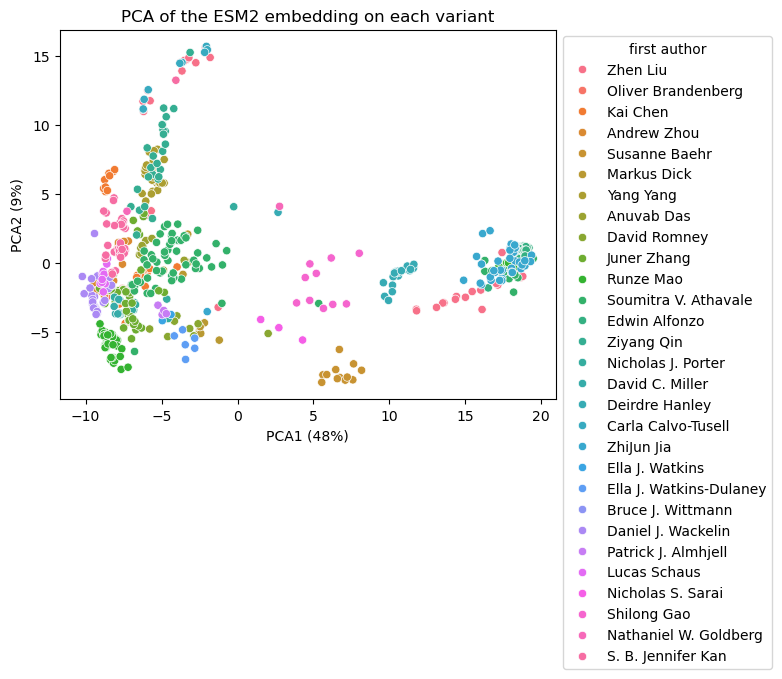

In [35]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X = np.array([x for x in rxn_embeddings_rxnfp['rxnfp'].values]).reshape((len(rxn_embeddings_rxnfp), len(rxn_embeddings_rxnfp['rxnfp'].values[0])))

pca_values = pca.fit_transform(X)
rxn_embeddings_rxnfp['PCA1'] = pca_values[:, 0]
rxn_embeddings_rxnfp['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(rxn_embeddings_rxnfp, x='PCA1', y='PCA2', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

# Compare this to ChemBERTa2

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

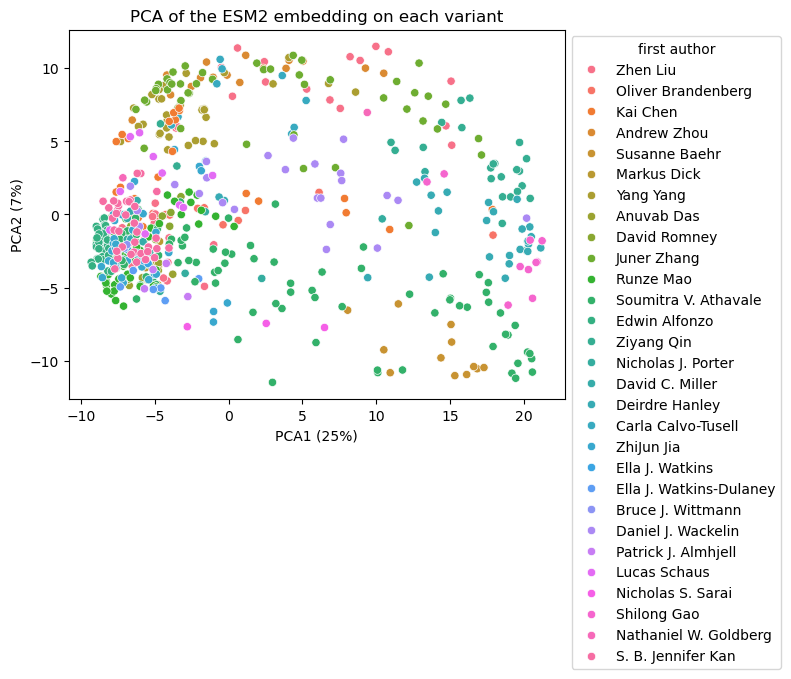

In [36]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
X = np.array([x for x in rxn_embeddings['chemberta'].values]).reshape((len(rxn_embeddings_rxnfp), len(rxn_embeddings['chemberta'].values[0])))

pca_values = pca.fit_transform(X)
rxn_embeddings_rxnfp['PCA1'] = pca_values[:, 0]
rxn_embeddings_rxnfp['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(rxn_embeddings_rxnfp, x='PCA1', y='PCA2', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

# Compare this to the background of natural function!

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

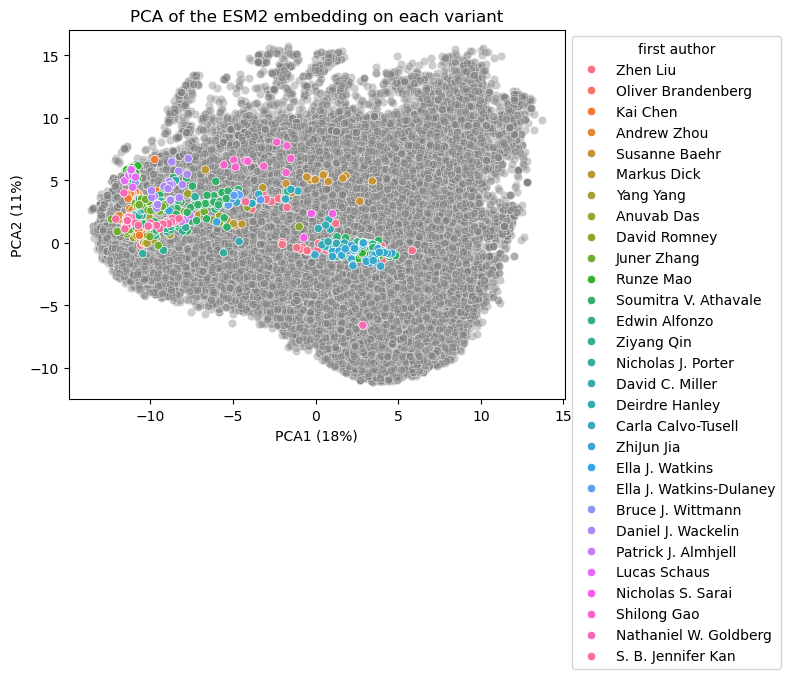

In [37]:
rxnfp_df = pd.read_pickle('/disk1/ariane/vscode/cec_degrader/manuscript/enzymemap_v2_brenda2023_reactions.pkl')
rxnfp_df['first author'] = 'Natural'
all_rxns = pd.concat([rxn_embeddings_rxnfp, rxnfp_df])
pca = PCA(n_components=2)
X = np.array([x for x in all_rxns['rxnfp'].values]).reshape((len(all_rxns), len(all_rxns['rxnfp'].values[0])))
pca_values = pca.fit_transform(X)
all_rxns['PCA1'] = pca_values[:, 0]
all_rxns['PCA2'] = pca_values[:, 1]

hue_order = [ 'Natural',
             'Andrew Zhou',
             'Anuvab Das',
             'Bruce J. Wittmann',
             'Carla Calvo-Tusell ',
             'Daniel J. Wackelin',
             'David C. Miller',
             'David Romney',
             'Deirdre Hanley',
             'Edwin Alfonzo',
             'Ella J. Watkins',
             'Ella J. Watkins-Dulaney',
             'Juner Zhang',
             'Kai Chen',
             'Lucas Schaus',
             'Markus Dick',
             'Nathaniel W. Goldberg',
             'Nicholas J. Porter',
             'Nicholas S. Sarai',
             'Oliver Brandenberg',
             'Patrick J. Almhjell',
             'Runze Mao',
             'S. B. Jennifer Kan',
             'Shilong Gao',
             'Soumitra V. Athavale',
             'Susanne Baehr',
             'Yang Yang',
             'Zhen Liu',
             'ZhiJun Jia',
             'Ziyang Qin']

ax = sns.scatterplot(all_rxns[all_rxns['first author'] == 'Natural'], x='PCA1', y='PCA2', color='grey', alpha=0.4)
ax = sns.scatterplot(all_rxns[all_rxns['first author'] != 'Natural'], x='PCA1', y='PCA2', hue='first author')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')